# Task 3
TO build a model to predict the ID of a card

##### Importing necessary modules

In [1]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications.vgg16 import VGG16

##### Reading train and test card pickle file

In [2]:
result_dir = 'iva_files/results/'
train_card_file = result_dir + 'train_card_seperated.pkl'
test_card_file = result_dir + 'test_card_seperated.pkl'
train_cards_df = pd.read_pickle(train_card_file)
test_cards_df = pd.read_pickle(test_card_file)
print('Images in train file -', len(train_cards_df))
print('Images in test file -', len(test_cards_df))

Images in train file - 209
Images in test file - 90


##### Getting X and Y from both the train and test dataframe

In [3]:
x = []
y = []
for card in train_cards_df['Cards']:
    x.append(card)
for card in test_cards_df['Cards']:
    x.append(card)
for card in train_cards_df['ID']:
    y.append([card])
for card in test_cards_df['ID']:
    y.append([card])
x = np.array(x, dtype=object)
y = np.array(y, dtype=np.int8)

##### Data Preprocessing

In [4]:
height = 224
width = 224
num_classes = 275
x = np.array([cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA) for img in x])
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

##### Viewing a random image for checking purpose

The ID of the card is 31


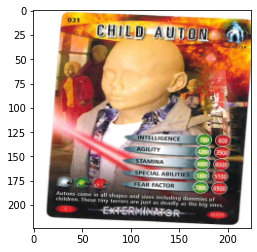

In [5]:
pos = 6
img = x[pos]
print('The ID of the card is',np.argmax(y[pos]))
plt.imshow(img)
plt.show()

##### Final shape check before we start data augmentation

In [6]:
print(x.shape)
print(y.shape)

(299, 224, 224, 3)
(299, 275)


##### Spliting the data 80-10-10 and applying data augmentation on train test

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) # Split it in 80-20
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5) # Spliting the 20 as 10-10
# Applying data augmentation only for training set
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Applying data augmentation only for validation and testing set
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow(x=x_train, y=y_train, batch_size=10)
valid_generator = test_datagen.flow(x=x_valid, y=y_valid, batch_size=10)
test_generator = test_datagen.flow(x=x_test, y=y_test, batch_size=10)

##### Building a transfer learning model

In [8]:
tf.keras.backend.clear_session()
vgg_16 = VGG16() # VGG16 model for transfer learning and its a functional model
my_model = Sequential() # Making our model as a sequential model
for layers in vgg_16.layers[:-1]: # Adding layers except last layer
  my_model.add(layers) # Adding layer to sequential model
for layers in my_model.layers:
  layers.trainable = False # making layers as non-trainable for transfer learning
my_model.add(Dense(num_classes, activation='softmax')) # adding the last layer for our card ID detection
my_model.summary() # Notice that there are some non-trainable parameters and some trainable parameters

553476096/553467096 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                       

### !!! Warning !!!
Training the model

In [9]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam() # Default learning rate is 0.001
batch_size = 10
epochs = 150
my_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = my_model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)

Epoch 1/150
24/24 [==============================] - 16s 220ms/step - loss: 8.8246 - accuracy: 0.0167 - val_loss: 8.4121 - val_accuracy: 0.0000e+00
Epoch 2/150
24/24 [==============================] - 3s 125ms/step - loss: 5.4549 - accuracy: 0.0711 - val_loss: 7.6221 - val_accuracy: 0.0000e+00
Epoch 3/150
24/24 [==============================] - 3s 124ms/step - loss: 5.1196 - accuracy: 0.0711 - val_loss: 7.6588 - val_accuracy: 0.0000e+00
Epoch 4/150
24/24 [==============================] - 3s 125ms/step - loss: 4.9076 - accuracy: 0.1172 - val_loss: 6.8945 - val_accuracy: 0.1333
Epoch 5/150
24/24 [==============================] - 3s 128ms/step - loss: 4.7178 - accuracy: 0.1004 - val_loss: 6.6618 - val_accuracy: 0.2333
Epoch 6/150
24/24 [==============================] - 3s 124ms/step - loss: 4.1690 - accuracy: 0.1674 - val_loss: 6.8557 - val_accuracy: 0.0333
Epoch 7/150
24/24 [==============================] - 3s 125ms/step - loss: 4.1908 - accuracy: 0.1925 - val_loss: 6.5341 - val_acc

##### PLotting to check data overfit

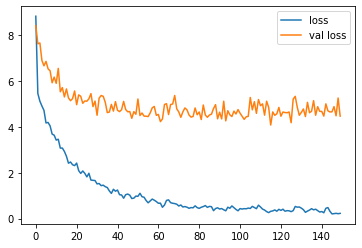

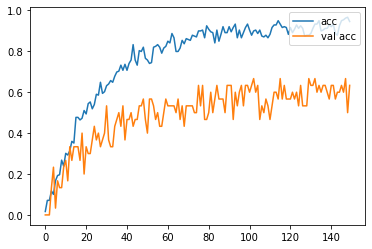

In [10]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc="upper right")
plt.show()
print()
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val acc')
plt.legend(loc="upper right")
plt.show()

##### Testing the model on test set

In [31]:
loss, acc = my_model.evaluate(test_generator)
print('Loss on test dataset -', loss)
print('Accuracy on test dataset - '+ str(acc*100) +'%')

3/3 [==============================] - 0s 79ms/step - loss: 3.9210 - accuracy: 0.6667
Loss on test dataset - 3.9209799766540527
Accuracy on test dataset - 66.66666865348816%


##### Saving model for task 4

In [32]:
my_model.save('output_files/iva_task3_transfer.h5')